In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
from scipy.stats import chi2
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import swifter
from sklearn.model_selection import train_test_split
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec

In [3]:
# from tqdm import tqdm
# import zipfile
# with zipfile.ZipFile("txt_reviews.zip", 'r') as zip_ref:
#     zip_ref.extractall("data/")


In [4]:
# ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,ReviewSummary,ReviewText = [],[],[],[],[],[],[],[],[]
# for file in glob.glob("data/txt_reviews/*.txt"):
#     configs = Properties(process_escapes_in_values=False)
#     with open(file, 'rb') as config_file:
#         configs.load(config_file)
#         ProductId.append(configs.get("ProductId").data)
#         UserId.append(configs.get("UserId").data)
#         ProfileName.append(configs.get("ProfileName").data)
#         HelpfulnessNumerator.append(configs.get("HelpfulnessNumerator").data)
#         HelpfulnessDenominator.append(configs.get("HelpfulnessDenominator").data)
#         Score.append(configs.get("Score").data)
#         Time.append(configs.get("Time").data)
#         ReviewSummary.append(configs.get("ReviewSummary").data)
#         ReviewText.append(configs.get("ReviewText","empty").data)
        
# data = pd.DataFrame({'ProductId':ProductId,'UserId':UserId,'ProfileName':ProfileName,'HelpfulnessNumerator':HelpfulnessNumerator,'HelpfulnessDenominator':HelpfulnessDenominator,'Score':Score,'Time':Time,'ReviewSummary':ReviewSummary,'ReviewText':ReviewText})


In [5]:
df=pd.read_csv(r"C:\Users\ceh\Downloads\txt_reviews.csv")

In [6]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,ReviewSummary,ReviewText
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...
3,B006F2NYI2,A132DJVI37RB4X,Scottdrum,2,5,2,1332374400,"Not hot, not habanero","I have to admit, I was a sucker for the large ..."
4,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,1337472000,The best weve tried so far,We have a 7 week old... He had gas and constip...


In [7]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


# Renaming columns

In [8]:
new_names=[]
for i in df.columns:
    new_names.append(" ".join((re.sub( r"([A-Z])", r" \1", i).split())).replace(" ","_").lower())
new_names
df.set_axis(new_names,axis='columns' , inplace=True)

In [9]:
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,review_summary,review_text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...
3,B006F2NYI2,A132DJVI37RB4X,Scottdrum,2,5,2,1332374400,"Not hot, not habanero","I have to admit, I was a sucker for the large ..."
4,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,1337472000,The best weve tried so far,We have a 7 week old... He had gas and constip...


In [10]:
df.shape

(568454, 9)

# Number of rows matched that is 568454

# Coverting column time from integer into datetime also renaming column time to date 

In [11]:
df.time=pd.to_datetime(df.time, unit='s')
df.rename(columns={'time':'date'},inplace=True)
print(min(df.date),max(df.date))

1999-10-08 00:00:00 2012-10-26 00:00:00


# Date range from 08-october-1999 to 26-october-2012 

In [12]:
print(df.user_id.nunique())
print(df.product_id.nunique())
count=0
for i in df.user_id.value_counts():
    if i>50:
        count+=1
print(count)

256059
74258
260


# Total user_id and product_id are 256059 and 74258 also 260 user have more than 50 reviews

# Dropping duplicates

In [13]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df

281


,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,2012-10-26,Healthy Dog Food,This is a very healthy dog food. Good for thei...
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,2012-03-08,Bad,I fed this to my Golden Retriever and he hated...
3,B006F2NYI2,A132DJVI37RB4X,Scottdrum,2,5,2,2012-03-22,"Not hot, not habanero","I have to admit, I was a sucker for the large ..."
4,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,2012-05-20,The best weve tried so far,We have a 7 week old... He had gas and constip...
...,...,...,...,...,...,...,...,...,...
568449,B000LQORDE,AL22WN8RBBOW7,"LifeInTheCity ""trogg""",2,5,5,2009-10-25,Good Stuff,I love these noodle. A little to spicy for th...
568450,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,2009-09-28,yummy!,I just love it and will buy another box when I...
568451,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,2009-08-23,Tastes like More!,My late father in law used to have a rating sy...
568452,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,2009-03-23,Great ramen,This is my favorite brand of Korean ramen. It ...


# Working on Null values 

In [14]:
df.isnull().sum()

product_id                  0
user_id                     0
profile_name               16
helpfulness_numerator       0
helpfulness_denominator     0
score                       0
date                        0
review_summary             27
review_text                 0
dtype: int64

In [15]:
df[df.profile_name.isnull()].head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text
7282,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,2012-01-17,Finally!,"You cannot find this in the stores anymore, it..."
41796,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,2011-12-24,awesome,i love them they are amazing I would eat them ...
70216,B000CQID1A,AGT3BYX5P9SLH,NaN,0,0,5,2011-12-24,awesome,i love them they are amazing I would eat them ...
80517,B001FA1L9I,AC9U70TRGPDGJ,NaN,0,0,5,2010-11-12,very good,came in proper packaging. Have loved British ...
172336,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,2011-08-29,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...


In [16]:
df[df.user_id=='A36BVYD0NT7Z0F']

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text
172336,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,2011-08-29,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
320834,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,2010-07-06,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
368445,B000W5P0KI,A36BVYD0NT7Z0F,NaN,13,21,1,2011-03-01,WARNING: Please read before feeding,WARNING: I use to feed my dogs Orijen 75% pro...


In [17]:
df[df.review_summary.isnull()]

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text
1234,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
3314,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
19465,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
61906,B0009VO58S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
86992,B00073IVAQ,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
109418,B000FVBYCW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
125216,B00020HHAO,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
152853,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,2012-02-07,NaN,This is a cool system only problem is that the...
215454,B00020HHM2,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...
221663,B00142BX68,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...


In [18]:
df[(df.user_id=='A22R17YPXEULEZ') & (df.product_id=='B001H9XOEW') & (df.profile_name=='Liz Wong')]

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text
325036,B001H9XOEW,A22R17YPXEULEZ,Liz Wong,0,0,3,2012-04-16,NaN,I like the product and tried it before I pucha...


# Droppping Null values [No pattern found]

In [19]:
df.dropna(inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568130 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   product_id               568130 non-null  object        
 1   user_id                  568130 non-null  object        
 2   profile_name             568130 non-null  object        
 3   helpfulness_numerator    568130 non-null  int64         
 4   helpfulness_denominator  568130 non-null  int64         
 5   score                    568130 non-null  int64         
 6   date                     568130 non-null  datetime64[ns]
 7   review_summary           568130 non-null  object        
 8   review_text              568130 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 43.3+ MB


# Creating new column named Helpfulness resetting index

In [21]:
df['helpfulness']=df.helpfulness_numerator/df.helpfulness_denominator
df.helpfulness.fillna(0,inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,2012-10-26,Healthy Dog Food,This is a very healthy dog food. Good for thei...,0.0
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,2012-03-08,Bad,I fed this to my Golden Retriever and he hated...,0.0
3,B006F2NYI2,A132DJVI37RB4X,Scottdrum,2,5,2,2012-03-22,"Not hot, not habanero","I have to admit, I was a sucker for the large ...",0.4
4,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,2012-05-20,The best weve tried so far,We have a 7 week old... He had gas and constip...,0.0


# Sorting data based on date in asceding

In [22]:
df = df.sort_values(by=['date'], ascending=True)
df.reset_index(drop=True,inplace=True)

# Study of columns

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568130 entries, 0 to 568129
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   product_id               568130 non-null  object        
 1   user_id                  568130 non-null  object        
 2   profile_name             568130 non-null  object        
 3   helpfulness_numerator    568130 non-null  int64         
 4   helpfulness_denominator  568130 non-null  int64         
 5   score                    568130 non-null  int64         
 6   date                     568130 non-null  datetime64[ns]
 7   review_summary           568130 non-null  object        
 8   review_text              568130 non-null  object        
 9   helpfulness              568130 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 43.3+ MB


In [24]:
df.describe()

,helpfulness_numerator,helpfulness_denominator,score,helpfulness
count,568130.000000,568130.000000,568130.000000,568130.000000
mean,1.744263,2.228305,4.183328,0.407996
std,7.638418,8.290395,1.310319,0.462087
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,4.000000,0.000000
50%,0.000000,1.000000,5.000000,0.000000
75%,2.000000,2.000000,5.000000,1.000000
max,866.000000,923.000000,5.000000,3.000000


# Total number of products is 74258 and top 5 products

In [284]:
print(df.product_id.nunique())
print(df.product_id.value_counts()[:10])

74258
B007JFMH8M    913
B002QWHJOU    631
B0026RQTGE    631
B002QWP8H0    631
B002QWP89S    631
B003B3OOPA    623
B001EO5Q64    567
B001RVFERK    564
B000VK8AVK    564
B0026KPDG8    564
Name: product_id, dtype: int64


# Total number of user

In [26]:
df.user_id.nunique()

256047

# Range of score is 1 - 5
# Range of helpfulness is 0 - 3

# Creating news column from given columns

In [27]:
df['len_review_text']=df.review_text.apply(lambda x : len(x.split()))
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,74
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,78
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,29
3,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36
4,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36


In [264]:
df['len_review_summary']=df.review_summary.apply(lambda x : len(x.split()))
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment,len_review_summary
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,74,useless,positive,4
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,78,very useful,positive,12
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,29,useless,positive,2
3,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive,5
4,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive,5


In [228]:
df['usefulness']=df.helpfulness.apply(lambda x: 'very useful' if (x>=0.75) else ('moderate useful' if (0.25<x<0.75) else 'useless'))
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,74,useless,positive
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,78,very useful,positive
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,29,useless,positive
3,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive
4,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive


In [29]:
df['sentiment']=df.score.apply(lambda x: 'positive' if ((x==5) or (x==4)) else ('neutral' if (x==3) else 'negative'))
df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,74,useless,positive
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,78,very useful,positive
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,29,useless,positive
3,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,useful,positive
4,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,useful,positive


# top 10 person with number of positive reviews given by him/her

In [268]:
pos_df=df[df.score==5]
pos_df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment,len_review_summary
0,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,74,useless,positive,4
1,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,78,very useful,positive,12
2,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,29,useless,positive,2
3,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive,5
4,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",0.5,36,moderate useful,positive,5


In [271]:
person_with_most_pos_num_of_review,pos_reviews_count=pos_df.profile_name.value_counts()[:10].index,pos_df.profile_name.value_counts()[:10].values
person_with_most_pos_num_of_review,pos_reviews_count

(Index(['Rebecca of Amazon "The Rebecca Review"', 'Gary Peterson',
        'C. F. Hill "CFH"', 'Chris', 'O. Brown "Ms. O. Khannah-Brown"', 'Linda',
        'John', 'Karen', 'Gunner', 'c2'],
       dtype='object'),
 array([326, 286, 270, 237, 237, 195, 187, 185, 184, 172], dtype=int64))

Text(0.5, 1.0, 'Top 10 person vs pos_reviews_count')

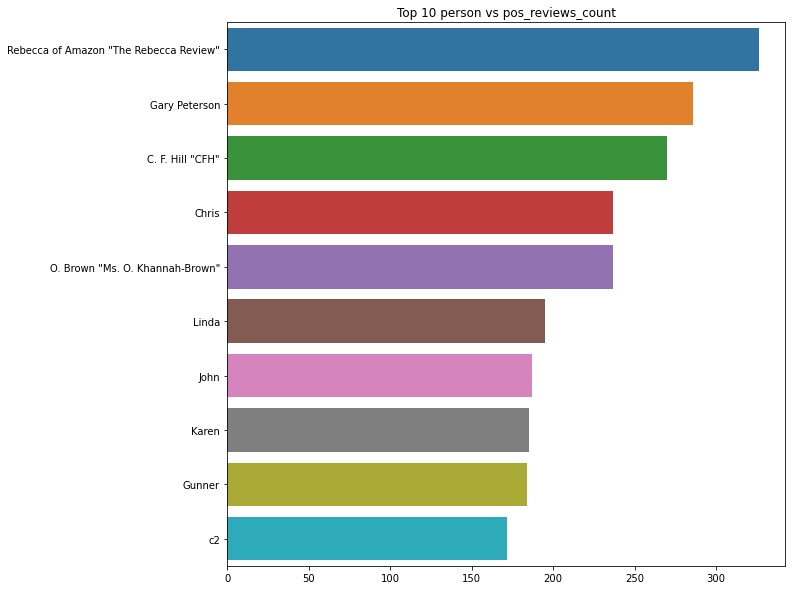

In [276]:
plt.figure(figsize=(10,10))
sns.barplot(y=person_with_most_pos_num_of_review,x=pos_reviews_count);
plt.title('Top 10 person vs pos_reviews_count')

# products vs reviews count when score=5

In [275]:
pos_df.product_id.value_counts()

B007JFMH8M    624
B003B3OOPA    517
B000NMJWZO    502
B0026RQTGE    497
B002QWP8H0    497
             ... 
B004U3QX6I      1
B001AN1CRQ      1
B003AYEHVQ      1
B003XQINIY      1
B005C7R8HE      1
Name: product_id, Length: 60718, dtype: int64

In [281]:
product_with_most_pos_num_of_review,pos_reviews_count_product=pos_df.product_id.value_counts()[:10].index,pos_df.product_id.value_counts()[:10].values
product_with_most_pos_num_of_review,pos_reviews_count_product

(Index(['B007JFMH8M', 'B003B3OOPA', 'B000NMJWZO', 'B0026RQTGE', 'B002QWP8H0',
        'B002QWHJOU', 'B002QWP89S', 'B001EO5Q64', 'B000VK8AVK', 'B007M83302'],
       dtype='object'),
 array([624, 517, 502, 497, 497, 497, 497, 474, 369, 369], dtype=int64))

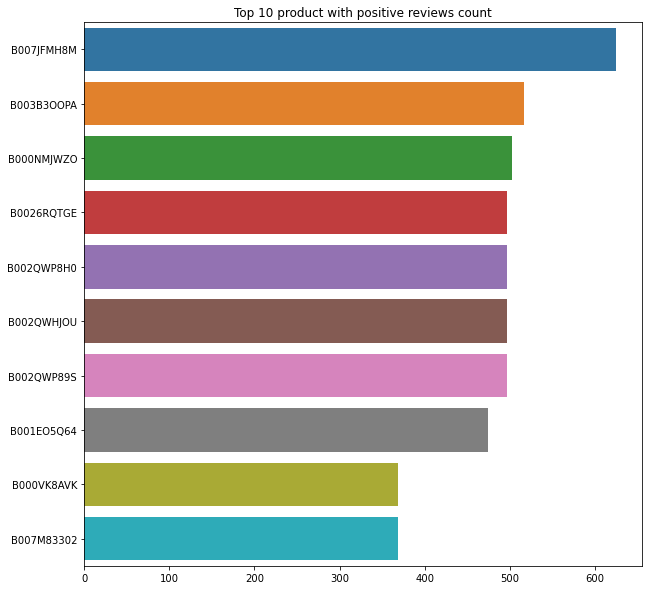

In [292]:
plt.figure(figsize=(10,10))
sns.barplot(y=product_with_most_pos_num_of_review,x=pos_reviews_count_product);
plt.title('Top 10 product with positive reviews count');

# top 10 person with number of negative reviews given by him/her

In [265]:
neg_df=df[df.score==1]
neg_df.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment,len_review_summary
10,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",0.826087,68,very useful,negative,7
11,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",0.826087,68,very useful,negative,7
12,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",0.826087,68,very useful,negative,7
41,B00004RYGX,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,0.913043,138,very useful,negative,4
42,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,0.913043,138,very useful,negative,4


In [291]:
df[df.profile_name=='christopher hayes']

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,date,review_summary,review_text,helpfulness,len_review_text,usefulness,sentiment,len_review_summary
197135,B003MA8P02,A3TVZM3ZIXG8YW,christopher hayes,19,21,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.904762,864,very useful,negative,10
197136,B009GHI5Q4,A3TVZM3ZIXG8YW,christopher hayes,3,3,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",1.000000,864,very useful,negative,10
197140,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,3,3,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",1.000000,864,very useful,negative,10
197142,B0006345PW,A3TVZM3ZIXG8YW,christopher hayes,19,21,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.904762,864,very useful,negative,10
197143,B009GHI5Q4,A3TVZM3ZIXG8YW,christopher hayes,7,9,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.777778,864,very useful,negative,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197633,B000633QVG,A3TVZM3ZIXG8YW,christopher hayes,0,2,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.000000,864,useless,negative,10
197635,B003M60K54,A3TVZM3ZIXG8YW,christopher hayes,19,21,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.904762,864,very useful,negative,10
197637,B003MWBFMK,A3TVZM3ZIXG8YW,christopher hayes,2,4,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.500000,864,moderate useful,negative,10
197638,B003ANFMY8,A3TVZM3ZIXG8YW,christopher hayes,19,21,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0.904762,864,very useful,negative,10


In [266]:
person_with_most_neg_num_of_review,neg_reviews_count=neg_df.profile_name.value_counts()[:10].index,neg_df.profile_name.value_counts()[:10].values
person_with_most_neg_num_of_review,neg_reviews_count

(Index(['christopher hayes', 'BreezyPaige', 'Amanda', 'Linda', 'Disappointed',
        'Chris', 'Ryan Johnson', 'David', 'Bigmac', 'Joe MacBu'],
       dtype='object'),
 array([182,  65,  55,  47,  44,  42,  42,  41,  39,  38], dtype=int64))

Text(0.5, 1.0, 'Top 10 person vs neg_reviews_count')

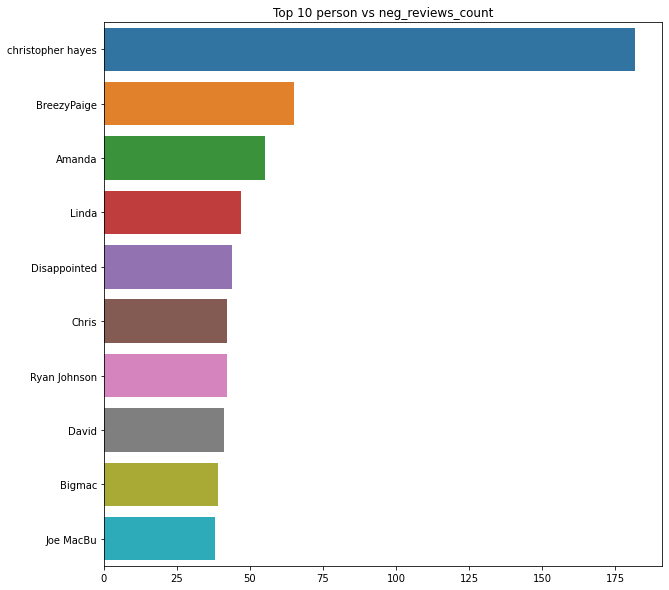

In [267]:
plt.figure(figsize=(10,10))
sns.barplot(y=person_with_most_neg_num_of_review,x=neg_reviews_count);
plt.title('Top 10 person vs neg_reviews_count')

# distribution of number of reviews is right tailed

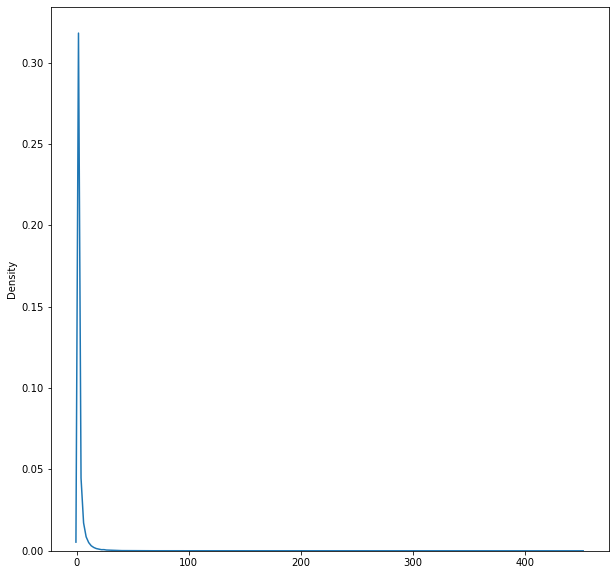

In [252]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=df.profile_name.value_counts().values);

# most reviews recevied from customer name

In [247]:
person_with_most_num_of_review,reviews_count=df.profile_name.value_counts()[:10].index,df.profile_name.value_counts()[:10].values
person_with_most_num_of_review,reviews_count

(Index(['C. F. Hill "CFH"', 'O. Brown "Ms. O. Khannah-Brown"', 'Gary Peterson',
        'Rebecca of Amazon "The Rebecca Review"', 'Chris', 'Linda', 'John',
        'Mike', 'c2', 'Laura'],
       dtype='object'),
 array([450, 418, 389, 365, 363, 290, 261, 260, 256, 253], dtype=int64))

Text(0.5, 1.0, 'Top 10 person vs reviews_count')

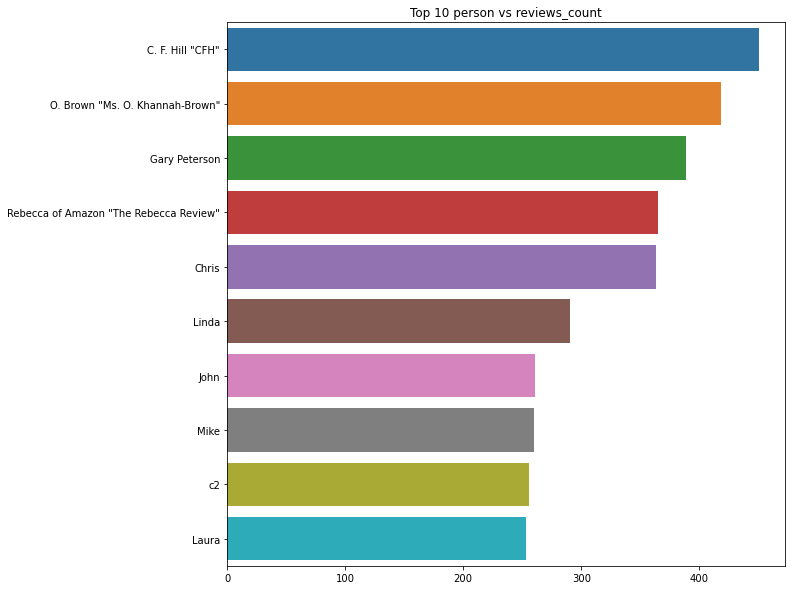

In [251]:
plt.figure(figsize=(10,10))
sns.barplot(y=person_with_most_num_of_review,x=reviews_count);
plt.title('Top 10 person vs reviews_count')

# top most frequent words of review_text 

In [224]:
all_words = []
for t in df['review_text']:
    all_words.extend(t.split())
set_all_words = set(all_words)
print(len(all_words),all_words[:50],len(set_all_words))

45579027 ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud.', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', "we're", 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain.', "he's", 'learned', 'about', 'whales,', 'India,', 'drooping', 'roses:', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all.', 'this'] 586931


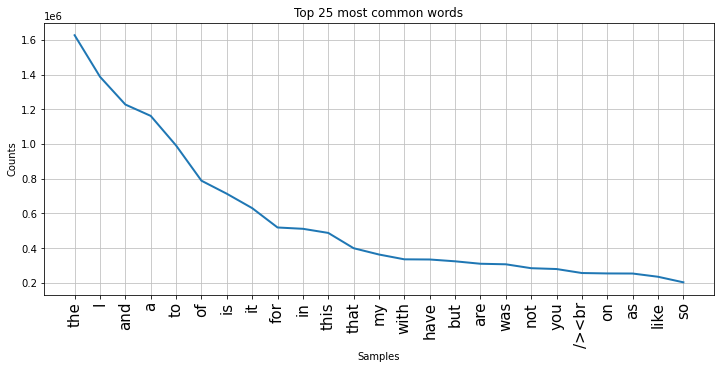

In [225]:
#Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

# top most frequent words of review_summary

In [226]:
all_words_summ = []
for t in df['review_summary']:
    all_words_summ.extend(t.split())
set_all_words_summ = set(all_words_summ)
print(len(all_words_summ),all_words_summ[:50],len(set_all_words_summ))

2336774 ['EVERY', 'book', 'is', 'educational', 'This', 'whole', 'series', 'is', 'great', 'way', 'to', 'spend', 'time', 'with', 'your', 'child', 'Entertainingl', 'Funny!', 'A', 'modern', 'day', 'fairy', 'tale', 'A', 'modern', 'day', 'fairy', 'tale', 'A', 'modern', 'day', 'fairy', 'tale', 'FANTASTIC!', 'GREAT', 'GREAT', 'GREAT', 'WARNING:', 'CLAMSHELL', 'EDITION', 'IS', 'EDITED', 'TV', 'VERSION', 'WARNING:', 'CLAMSHELL', 'EDITION', 'IS', 'EDITED', 'TV'] 104043


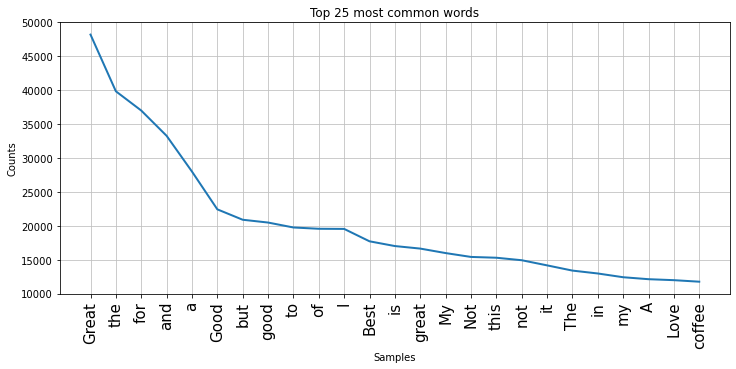

In [227]:
freq_dist = nltk.FreqDist(all_words_summ)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

# even useless data has score range of 1 to 4

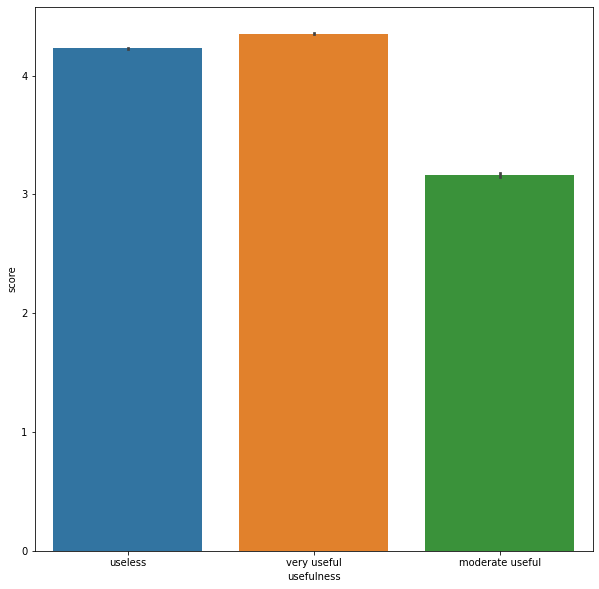

In [229]:
plt.figure(figsize=(10,10))
sns.barplot(y=df.score,x=df.usefulness);

# data not equally distributed

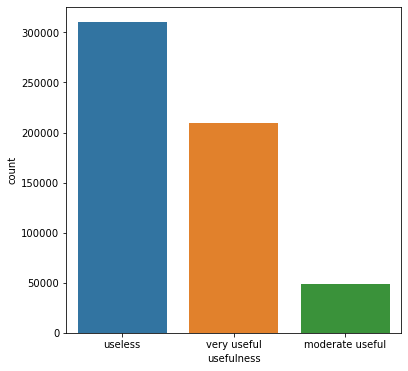

In [256]:
plt.figure(figsize=(6,6))
sns.countplot(x=df.usefulness);

In [293]:
# plt.figure(figsize=(6,6))
#sns.countplot(x=df.usefulness[df.usefulness!='useless']);

# frequency of score 5 that is positive revivew is alot more than negative reviews 

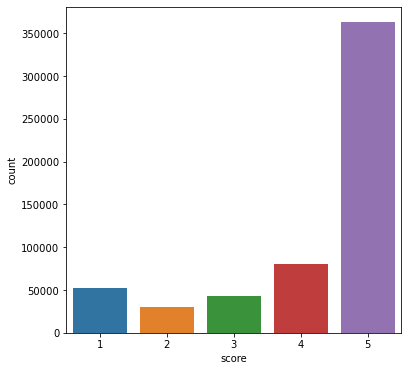

In [257]:
plt.figure(figsize=(6,6))
sns.countplot(x=df.score);

# number of reviews evrey year are exponentially increasing 

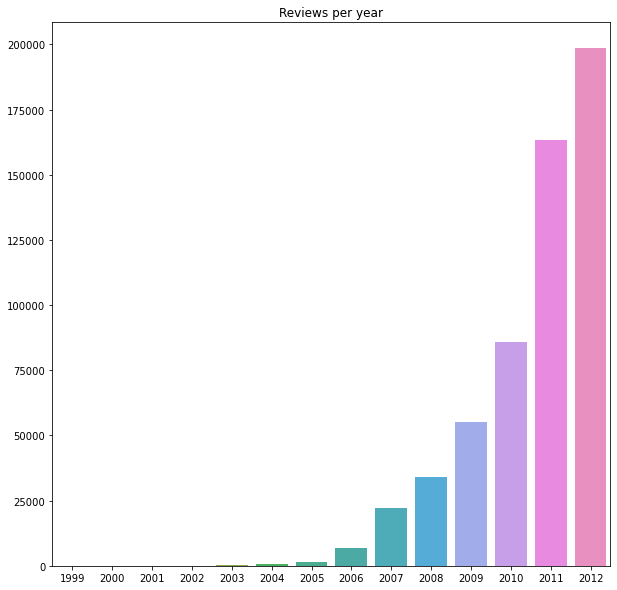

In [35]:
cnt = df.date.dt.year.value_counts()
cnt = cnt.sort_index()
plt.figure(figsize=(10,10))
sns.barplot(cnt.index, cnt.values)
plt.title('Reviews per year');

# on an average of 4000+ reviews are posted every month

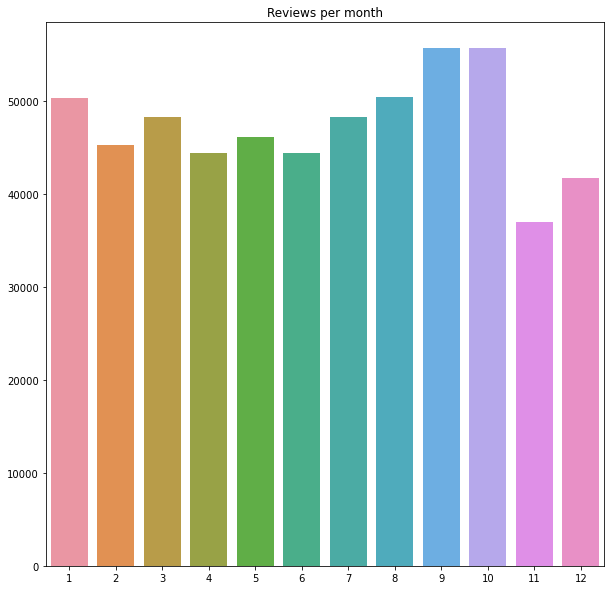

In [36]:
cnt = df.date.dt.month.value_counts()
cnt = cnt.sort_index()
plt.figure(figsize=(10,10))
sns.barplot(cnt.index, cnt.values)
plt.title('Reviews per month');

In [37]:
# cnt = df.date.dt.day.value_counts()
# cnt = cnt.sort_index()
# plt.figure(figsize=(10,10))
# sns.barplot(cnt.index, cnt.values)
# plt.title('Reviews per day');

# good reviews are overwhelmingly beating negative and neutral reviews

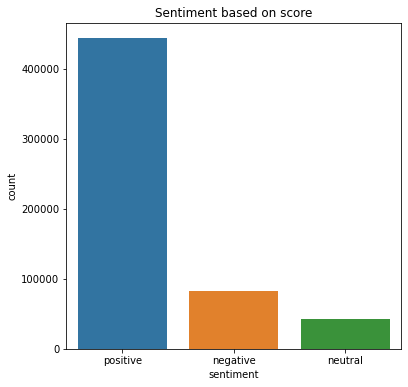

In [258]:
plt.figure(figsize=(6,6))
sns.countplot(x=df.sentiment);
plt.title('Sentiment based on score');

# heatmap

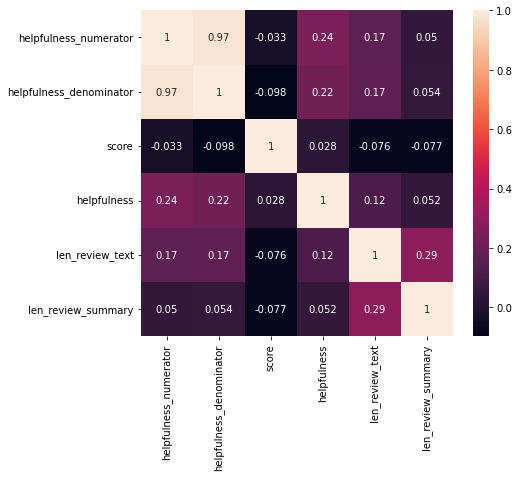

In [294]:
plt.figure(figsize=(7,6))
sns.heatmap(df.corr(),annot=True);

# from above graph score and helpfulness has positive very weak relationship

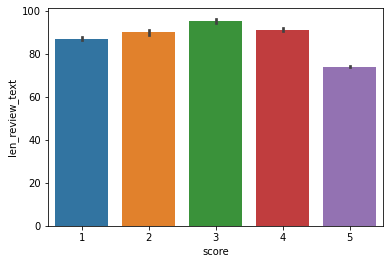

In [299]:
sns.barplot(y=df.len_review_text,x=df.score);

# sentiment vs len of review text

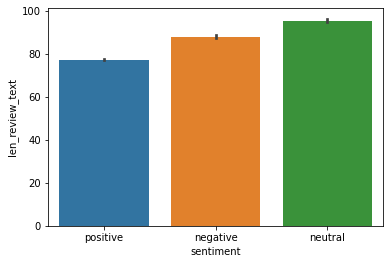

In [300]:
sns.barplot(y=df.len_review_text,x=df.sentiment);

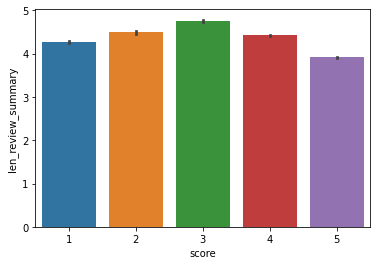

In [301]:
sns.barplot(y=df.len_review_summary,x=df.score);

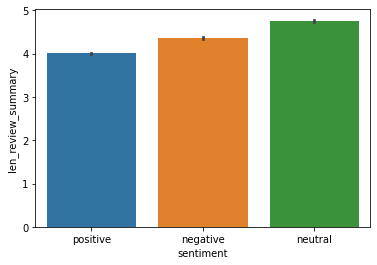

In [304]:
sns.barplot(y=df.len_review_summary,x=df.sentiment);

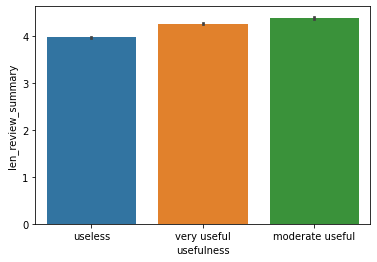

In [306]:
sns.barplot(y=df.len_review_summary,x=df.usefulness);

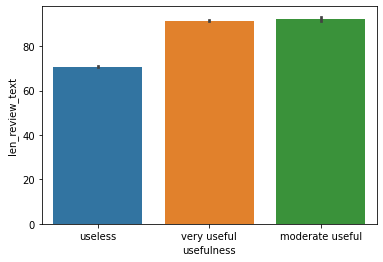

In [307]:
sns.barplot(y=df.len_review_text,x=df.usefulness);

# chi saqure testing

In [40]:
ct_table_ind=pd.crosstab(df["review_text"],df["score"])
print('contingency_table :\n',ct_table_ind)

contingency_table :
 score                                               1  2  3  4  5
review_text                                                      
! think I just ruined my dish. open this and po...  1  0  0  0  0
!!! PRODUCT HAS NOTHING TO DO WITH MARVEL!!! FA...  1  0  0  0  0
!!!<br />Animal digest? She does that on her ow...  0  0  1  0  0
!!HEY, these are BIG! There are actually two ca...  0  0  0  0  1
"  WITH  " ... Olive Oil.  What does this mean?...  0  0  1  0  0
...                                                .. .. .. .. ..
~<br /><br />These are sooooooooooooooooooooooo...  0  0  0  0  1
~<br />This is a `3 for the price of 1' review ...  0  0  0  1  0
~<br />This would be a great coffee drink to gr...  0  0  1  0  0
~Earth's Best Infant Formula Soy Iron, 13.2-Oun...  0  0  0  0  1
~Taste..... I was expecting it to taste pretty ...  0  1  0  0  0

[393565 rows x 5 columns]


In [41]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
# print("expected frequencies:\n",expected)

chi2 statistic:     2.2715e+06
p-value:            0
degrees of freedom: 1574256


In [42]:
ct_table_ind=pd.crosstab(df["review_summary"],df["score"])
print('contingency_table :\n',ct_table_ind)

contingency_table :
 score                                               1  2  3  4  5
review_summary                                                   
! It's HOT !                                        0  0  0  0  1
! Mmmmmmmmmm !                                      0  0  0  0  6
! WARNING !  Not for those who can't handle the...  0  0  0  0  1
!! NASTY !!                                         1  0  0  0  0
!!!                                                 0  0  0  0  1
...                                                .. .. .. .. ..
~~~TRIO OF ALL TIME FAVORITES~~~                    0  0  0  0  1
Â«:::D:::Â» Â«:::E:::Â» Â«:::L:::Â» Â«:::I:::Â»...  0  0  0  0  1
Â«:::G:::Â» Â«:::R:::Â» Â«:::E:::Â» Â«:::A:::Â»...  0  0  0  0  1
Â½ pounds, not 1.5                                  0  0  1  0  0
Ãwesome Coffee!!!                                  0  0  0  0  1

[295736 rows x 5 columns]


In [43]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
# print("expected frequencies:\n",expected)

chi2 statistic:     2.0068e+06
p-value:            0
degrees of freedom: 1182940


# Conclusion

In [ ]:
# the created data frame justify all the synopsis mentioned in given project[date,number of user vs reviews etc]
# score has almost zero impact on helpfulness
# # 'Rebecca of Amazon "The Rebecca Review"' gave most number of positive reviews
# 'B007JFMH8M' has most number of positive reviews
# 'christopher hayes' gave 182 reviews where all the reviews are negative
# 'C. F. Hill "CFH"' has most number of reviews given
# frequency of score 5 that is positive revivew is alot more than negative reviews
# positive reviews has lesser number of text compare to other
# longer text reviews doesn't always convey positivity / helpfulness
# every year number of reviews are higher than the previous year
# around 4000+ reviews got posted every month and september and october got highest number of reviews